# INSTALL ALL TOOLS

In [1]:
!pip install geopandas
!pip install shapely
!pip install pyshp

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 14.2MB/s 
     |████████████████████████████████| 14.7MB 307kB/s 
     |████████████████████████████████| 225kB 2.7MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=206487d674e79a0f740247b3b067042f63fbdb21a5fcac9ba7c2575d404d3394
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
import pandas as pd
import pylab as pl
import geopandas as gpd
import shapely
import json
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

# CONNECT TO GOOGLE DRIVE

In [0]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive

/content/gdrive


In [0]:
cd My\ Drive

/content/gdrive/My Drive


In [0]:
cd VoterReg/

/content/gdrive/My Drive/VoterReg


# LOAD IN SHAPE DATA

In [0]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

In [0]:
shp_path = 'shapefiles/Delaware_Districts_-__Representative.shp'
sf = shp.Reader(shp_path)

MAKE SURE THIS MATCHES THE NUMBER OF DISTRICTS WE HAVE (41)

In [0]:
len(sf.shapes())

41

WHAT DOES A SINGLE RECORD LOOK LIKE?

In [0]:
sf.records()[1]

Record #1: [2, '11', 20915, 18008, 2009, 175, 711, 15441, 13482, 1420, 406, 5884, 4416, 3726, 14026, 21901, -986, -0.045, 0.861, 0.0961, 0.0084, 0.034, 0.7383, 0.8731, 0.092, 0.0263, 0.4195, 0.3148, 0.2657, 0.6706, '', '', '', 'Jeffrey N. Spiegelman', 'R', '11', '150', 'http://legis.delaware.gov/legislature.nsf/ByDistrict/Representative11']

MAKE A FUNCTION THAT READS IN THE SHAPE FILES

In [0]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [0]:
df = read_shapefile(sf)
df.shape

(41, 39)

In [0]:
df.head()


,OBJECTID,DISTRICT,POPULATION,WHITE,BLACK,ASIAN,HISPANIC_O,F18_POP,F18_WHT,F18_BLK,H18_POP,DEMOCRATIC,REPUBLICAN,OTHER_PART,TOTAL__VOT,IDEAL_VALU,DEVIATION,F_DEVIATIO,F_WHITE,F_BLACK,F_ASIAN,F_HISPANIC,F_18_POP,F_18_WHT,F_18_BLK,F_H18_POP,F_DEMOCRAT,F_REPUBLIC,F_OTHER_PA,F_TOTAL__V,SHAPE_AREA,SHAPE_LEN_,OBJECTID_1,NAME,PARTY,DISTRICT_1,LEGSESSION,URL,coords
0,1,9,21263,16428,3977,322,514,16049,12308,3244,302,5841,4637,3324,13802,21901,-638,-0.0291,0.7726,0.1870,0.0151,0.0242,0.7548,0.7669,0.2021,0.0188,0.4232,0.3360,0.2408,0.6491,,,,Kevin S. Hensley,R,9,150,http://legis.delaware.gov/legislature.nsf/ByDi...,"[(-8412179.1729, 4800507.316200003), (-8412179..."
1,2,11,20915,18008,2009,175,711,15441,13482,1420,406,5884,4416,3726,14026,21901,-986,-0.0450,0.8610,0.0961,0.0084,0.0340,0.7383,0.8731,0.0920,0.0263,0.4195,0.3148,0.2657,0.6706,,,,Jeffrey N. Spiegelman,R,11,150,http://legis.delaware.gov/legislature.nsf/ByDi...,"[(-8424820.6991, 4783554.344400004), (-8424759..."
2,3,7,20971,16180,3236,907,862,16716,13294,2366,556,7927,5317,4149,17393,21901,-930,-0.0425,0.7715,0.1543,0.0433,0.0411,0.7971,0.7953,0.1415,0.0333,0.4558,0.3057,0.2385,0.8294,,,,Raymond Seigfried,D,7,150,http://legis.delaware.gov/legislature.nsf/ByDi...,"[(-8401485.1282, 4839839.399599999), (-8401419..."
3,4,12,22964,20444,564,1454,626,17868,16067,444,388,6765,8539,5305,20609,21901,1063,0.0485,0.8903,0.0246,0.0633,0.0273,0.7781,0.8992,0.0248,0.0217,0.3283,0.4143,0.2574,0.8974,,,,Krista Griffith,D,12,150,http://legis.delaware.gov/legislature.nsf/ByDi...,"[(-8410812.4747, 4842644.042300001), (-8410365..."
4,5,14,21224,19302,899,322,832,18404,17096,621,607,6982,6166,3816,16964,21901,-677,-0.0309,0.9094,0.0424,0.0152,0.0392,0.8671,0.9289,0.0337,0.0330,0.4116,0.3635,0.2249,0.7993,,,,Peter C. Schwartzkopf,D,14,150,http://legis.delaware.gov/legislature.nsf/ByDi...,"[(-8358991.864499999, 4693038.998199999), (-83..."


CREATE A MAPPING FUNCTION FOR A BASIC PLOT

In [0]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (10,10)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

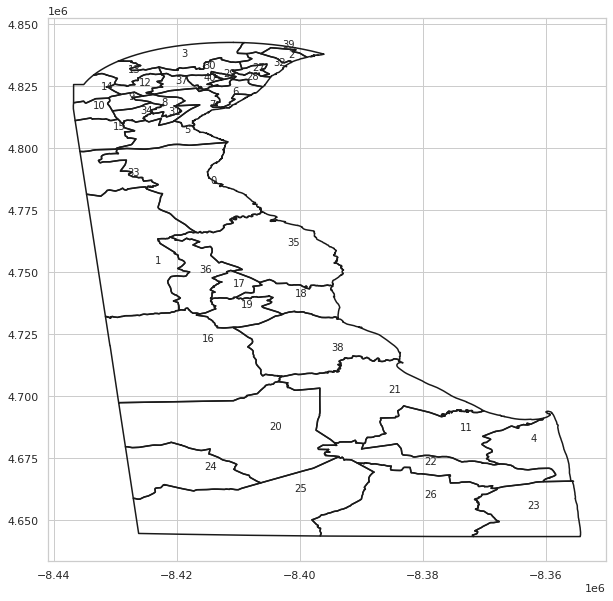

In [0]:
plot_map(sf)

In [0]:
def plot_map_fill_multiples_ids(title, district, sf, 
                                               x_lim = None, 
                                               y_lim = None, 
                                               figsize = (11,9), 
                                               color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in district:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color)
             
        x0 = np.mean(x_lon)
        y0 = np.mean(y_lat)
        plt.text(x0, y0, id, fontsize=10)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

<Figure size 792x648 with 0 Axes>

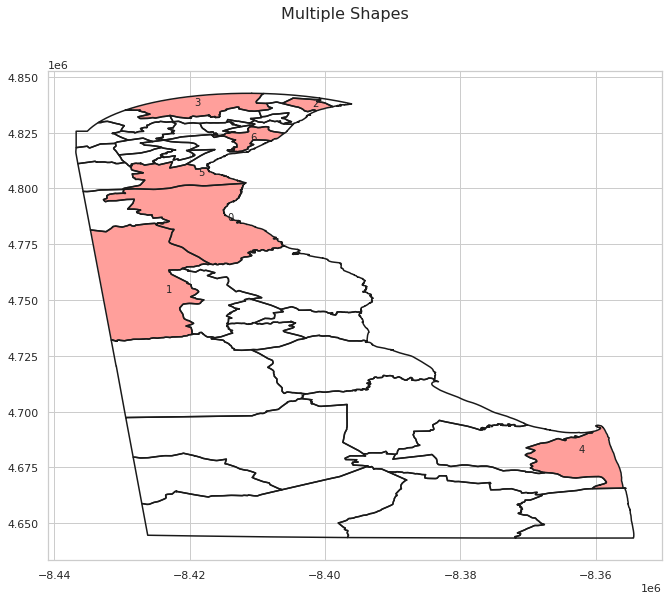

In [0]:
district_id = [0, 1, 2, 3, 4, 5, 6]
plot_map_fill_multiples_ids("Multiple Shapes", 
                            district_id, sf, color = 'r')

# COULDNT FIGURE OUT HOW TO ADAPT THE CODE TO FILL IN POPULATION DATA SO I STARTED TAKING ANOTHER APPROACH BELOW, BUT THE ABOVE CODE IS HELPFUL FOR HIGHLIGHTING CERTAIN DISTRICTS 

In [0]:
shapefile2 = 'shapefiles/Delaware_Districts_-__Representative.shp'
districts = gpd.read_file(shapefile2)

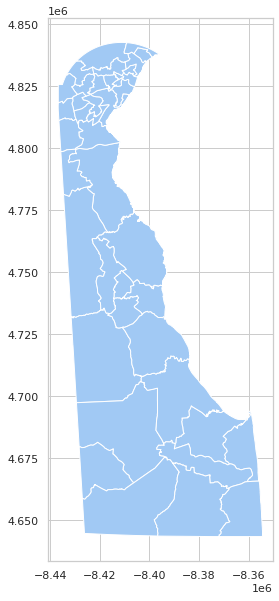

In [0]:
districts.plot(figsize(10,10))
plt.show()

# HEAT MAPS REPRESENTING TWO DIFFERENT POPULATIONS

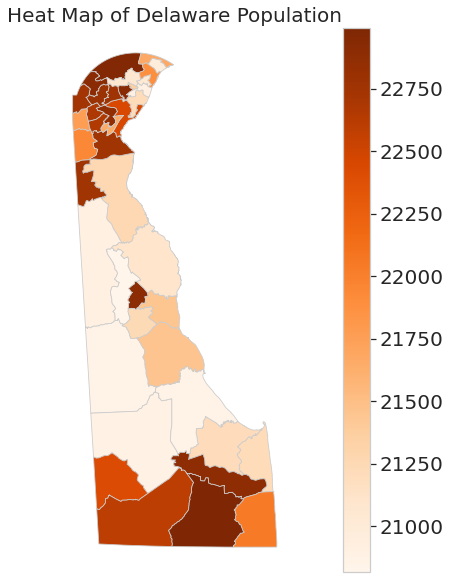

In [0]:

fig, ax = plt.subplots(1, figsize=(20, 10))
ax.axis('off')
ax.set_title('Heat Map of Delaware Population', fontdict={'fontsize': '20', 'fontweight' : '3'})
# Create colorbar as a legend
# empty array for the data range
# add the colorbar to the figure
# set the color bar label text size
color = 'Oranges'
vmin, vmax = districts.POPULATION.min(), districts.POPULATION.max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
# actually plot the map
districts.plot('POPULATION', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))
plt.show()

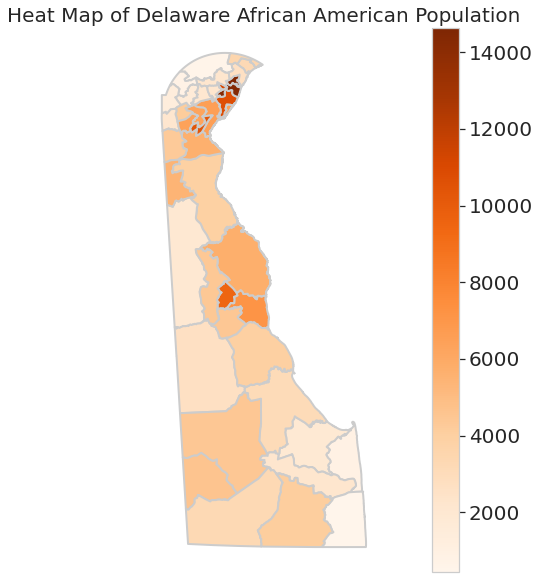

In [0]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.axis('off')
ax.set_title('Heat Map of Delaware African American Population', fontdict={'fontsize': '20', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = districts.BLACK.min(), districts.BLACK.max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

districts.plot('BLACK', cmap = color, linewidth = 2, ax=ax, edgecolor='0.8')
plt.show()

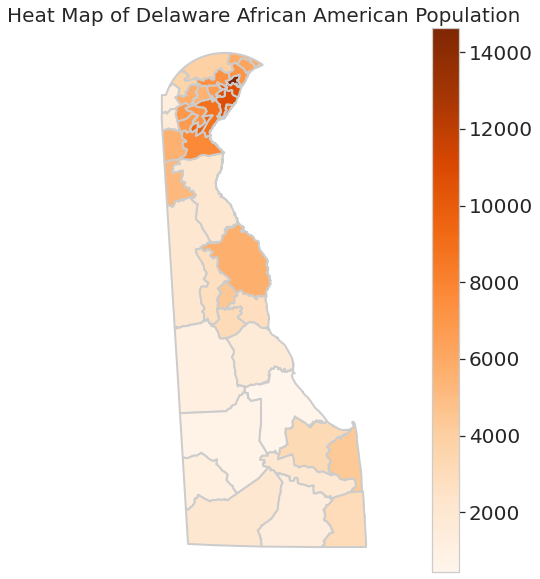

In [0]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.axis('off')
ax.set_title('Heat Map of Delaware Democrat Population', fontdict={'fontsize': '20', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = districts.BLACK.min(), districts.BLACK.max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

districts.plot('DEMOCRATIC', cmap = color, linewidth = 2, ax=ax, edgecolor='0.8')
plt.show()

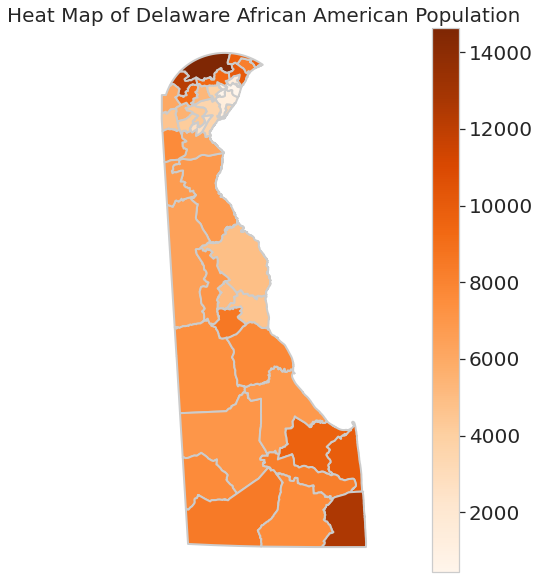

In [0]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.axis('off')
ax.set_title('Heat Map of Delaware Republican Population', fontdict={'fontsize': '20', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = districts.BLACK.min(), districts.BLACK.max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

districts.plot('REPUBLICAN', cmap = color, linewidth = 2, ax=ax, edgecolor='0.8')
plt.show()

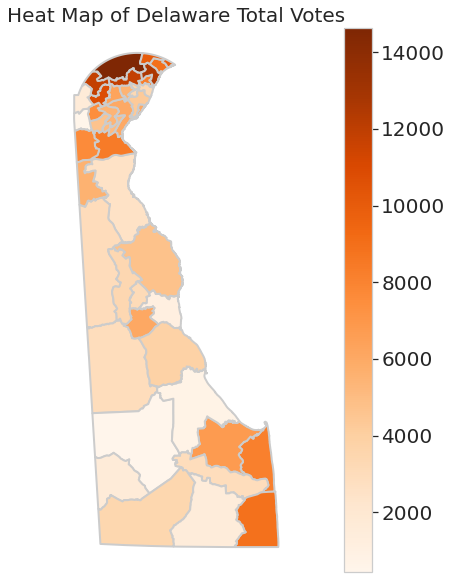

In [0]:

fig, ax = plt.subplots(1, figsize=(20, 10))
ax.axis('off')
ax.set_title('Heat Map of Delaware Total Votes', fontdict={'fontsize': '20', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = districts.BLACK.min(), districts.BLACK.max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

districts.plot('TOTAL__VOT', cmap = color, linewidth = 2, ax=ax, edgecolor='0.8')
plt.show()
